## Setup

In [ ]:
# Base python packages
import io
import PIL.Image as img
import requests

# Scipy packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Plotting parameters
mpl.rcParams['figure.facecolor'] = 'white'

## Image Compression

### Setup

In [ ]:
# Parameters
URL = ("https://cdn.mos.cms.futurecdn.net/"
       "VSy6kJDNq2pSXsCzb6cvYF-970-80.jpg")
RANKS = [1, 5, 10, 20, 40, 80]

In [ ]:
# Read image as 3D tensor
res = requests.get(URL)
T = np.array(img.open(io.BytesIO(res.content)))
print("Original image dimensions:", T.shape)

Original image dimensions: (546, 970, 3)


In [ ]:
# Convert to grayscale
X = np.mean(T, axis=-1)
print("Grayscale image dimensions:", X.shape)
print("Grayscale storage size:", round(X.size * X.itemsize / 1000), "kB")
# Record aspect ratio
asp = X.shape[1] / X.shape[0]

Grayscale image dimensions: (546, 970)
Grayscale storage size: 4237 kB


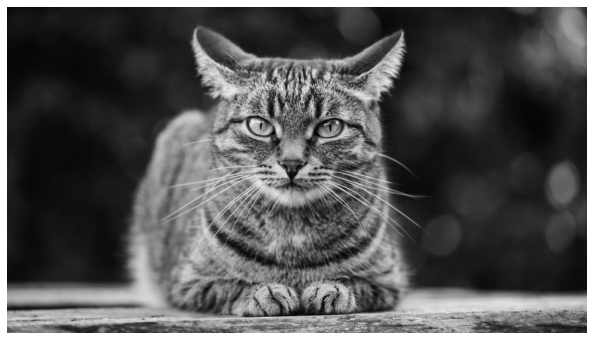

In [ ]:
# View original image
fig, ax = plt.subplots(figsize=(6 * asp, 6))
ax.imshow(X, cmap='gray')
ax.axis('off')
plt.show()

Note, in this example, we are storing the entire image as a matrix, rather than flattening images out to become columns of a matrix as we will in the eigenfaces example later.

### Decomposition

In [ ]:
# (Economical) Singular value decomposition
U, S, VT = np.linalg.svd(X, full_matrices=False)

In [ ]:
# Check new dimensions
print("U dimensions:", U.shape)
print("S dimensions:", S.shape)
print("VT dimensions:", VT.shape)

U dimensions: (546, 546)
S dimensions: (546,)
VT dimensions: (546, 970)


Don't be put off because $U$ is square whilst $V^T$ is not. This is only because $m < n$ unlike the examples we considered in the teaching sessions. Also, $\Sigma$ is stored as a one-dimensional array for efficiency.



In [ ]:
# Check new storage size
print("SVD storage size:", round((
    sum(A.size * A.itemsize for A in (U, S, VT))
) / 1000), "kB")

SVD storage size: 6626 kB


In other words, we've not saved storage yet but through truncation we can do just that.

### Truncation

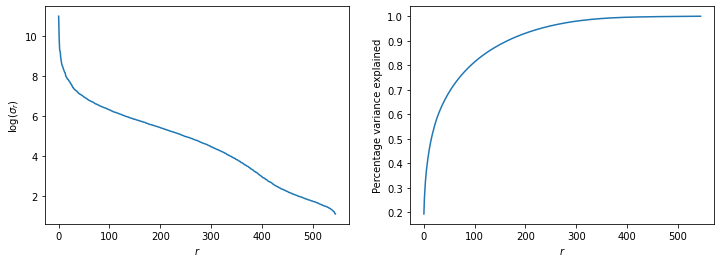

In [ ]:
# Singular value plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Logarithmic singular values
ax1.plot(np.log(S))
ax1.set_xlabel("$r$")
ax1.set_ylabel(r"$\log(\sigma_r)$")

# Percentage of variance explained
ax2.plot(np.cumsum(S) / np.sum(S))
ax2.set_xlabel("$r$")
ax2.set_ylabel("Percentage variance explained")

plt.show()

What is the memory use for a rank $r$ approximation? The original matrix had dimensions $m\times n$ so we require $O(mn)$ in storage. For a rank $r$ approximation we need $U$ of size $O(mr)$, $\Sigma$ of size $O(r)$ and $V^T$ of size $O(nr)$. Hence the total storage is $O((m+n)r)$; far more efficient.

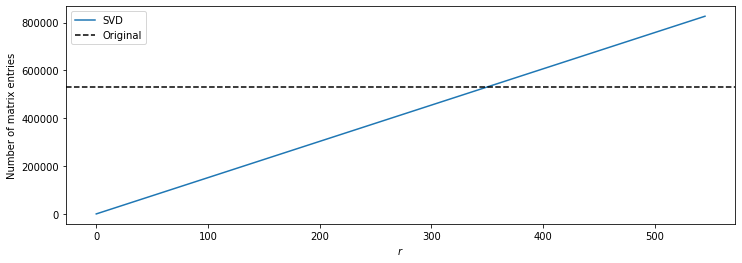

In [ ]:
# Storage size plot
fig, ax = plt.subplots(figsize=(12, 4))

# Logarithmic singular values
ax.plot((X.shape[0] + X.shape[1] + 1) * np.arange(min(X.shape[0], X.shape[1])),
        label="SVD")
ax.axhline(X.shape[0] * X.shape[1], label="Original", ls="--", c='k')
ax.set_xlabel("$r$")
ax.set_ylabel("Number of matrix entries")

plt.legend()
plt.show()

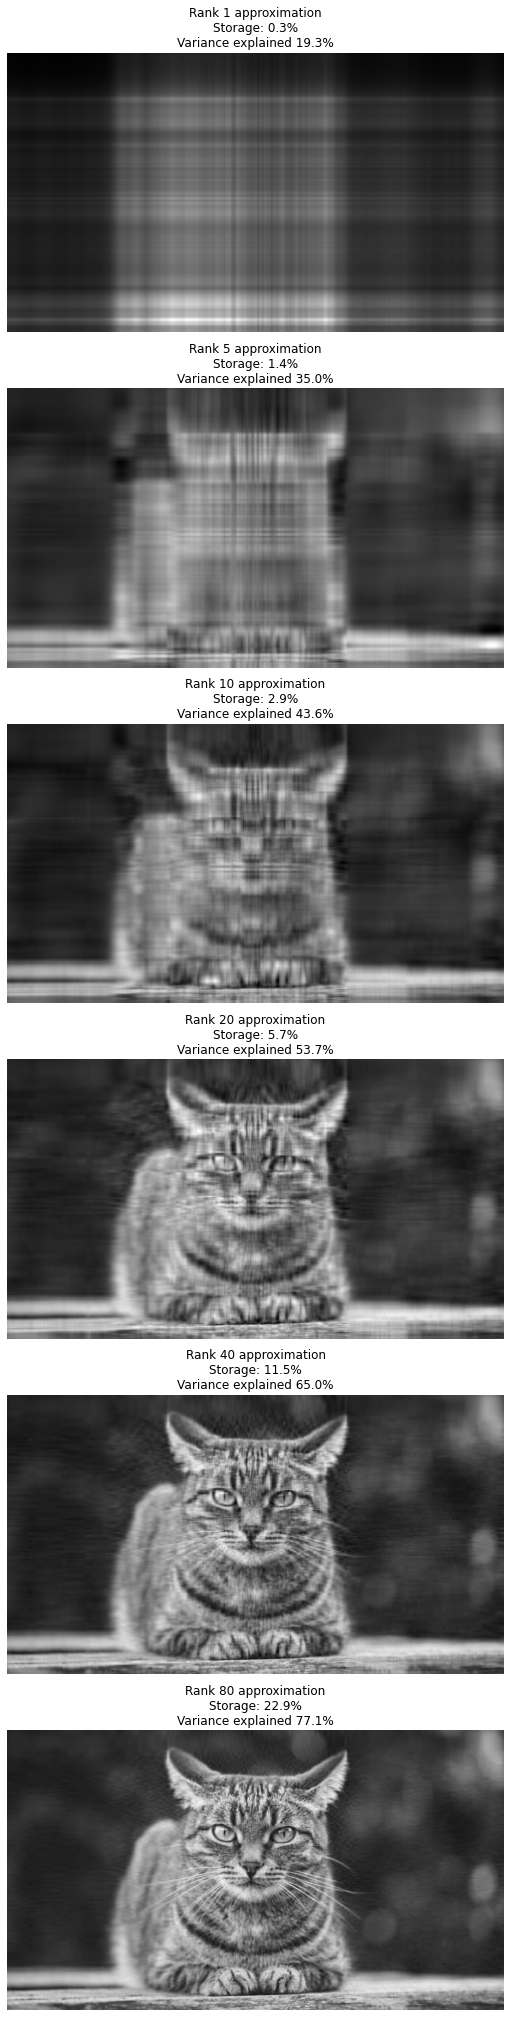

In [ ]:
# Reconstruct image using rank r approximation
fig, axs = plt.subplots(len(RANKS), 1, figsize = (6 * asp, 6 * len(RANKS)))
orig_storage = X.shape[0] * X.shape[1]
sum_sigma = np.sum(S)

for r, ax in zip(RANKS, axs):
  X_approx = U[:, :r] @ np.diag(S[:r]) @ VT[:r, :]
  storage_ratio = (r * (X.shape[0] + X.shape[1] + 1)) / orig_storage
  ax.imshow(X_approx, cmap='gray')
  ax.axis('off')
  ax.set_title(f"Rank {r} approximation\n" +
               f"Storage: {storage_ratio * 100:.01f}%\n" +
               f"Variance explained {np.sum(S[:r]) / sum_sigma * 100:.01f}%")
plt.show()

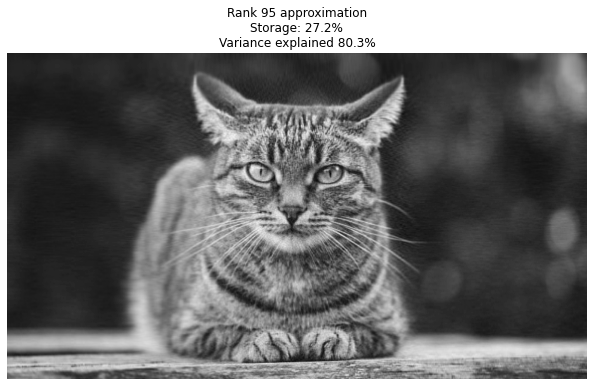

In [ ]:
# Optimal truncation
def omega(b):
  """An approximate form of omega(beta) given in Gavish & Donoho (2014)."""
  return 0.56 * b**3 - 0.95 * b**2 + 1.82 * b + 1.43

tau = omega(asp) * np.median(S)
r = np.argmax(S < tau) - 1

fig, ax = plt.subplots(figsize = (6 * asp, 6))
X_approx = U[:, :r] @ np.diag(S[:r]) @ VT[:r, :]
storage_ratio = (r * (X.shape[0] + X.shape[1] + 1)) / orig_storage
ax.imshow(X_approx, cmap='gray')
ax.axis('off')
ax.set_title(f"Rank {r} approximation\n" +
              f"Storage: {storage_ratio * 100:.01f}%\n" +
              f"Variance explained {np.sum(S[:r]) / sum_sigma * 100:.01f}%")
plt.show()

## Dimensionality Reduction

In this example we will look at performing dimensionality reduction (equivalent to PCA) on the Yale B faces dataset. This consists of 2410 images (192x168 pixels) of 10 human subjects under various poses and illumination conditions.

### Setup

In [ ]:
# Parameters
M = 192
N = 168
RANKS = [1, 5, 20, 100, 400, 1000]

In [ ]:
# Read faces matrix
X = np.load('faces.npy', allow_pickle=True)
print("Faces dimensions:", X.shape)
asp = N / M

Faces dimensions: (32256, 2410)


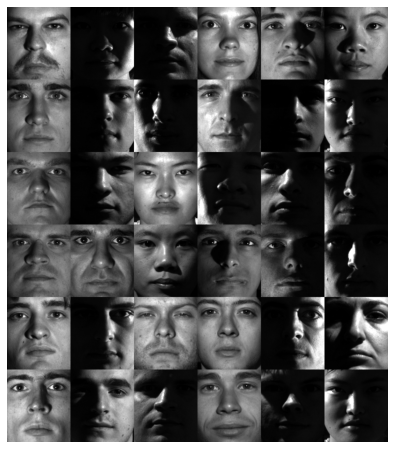

In [ ]:
# Randomly view 36 faces
collage = np.zeros((M * 6, N * 6))

for i in range(36):
  x, y = divmod(i, 6)
  j = np.random.choice(2410)
  collage[x*M:(x+1)*M, y*N:(y+1)*N] = X[:, j].reshape((N,M)).T

fig, ax = plt.subplots(figsize = (8 * asp, 8))
ax.imshow(collage, cmap='gray')
ax.axis('off')
plt.show()

In [ ]:
# Hold back one face for later
holdback_idx = 253
X = np.delete(X, holdback_idx, axis=1)
holdback = X[:, holdback_idx]

### Decomposition

In [ ]:
# (Economical) Singular value decomposition on centered data
mu = np.mean(X, axis=1) # size = (n*m, 1)
U, S, VT = np.linalg.svd(X - np.tile(mu, (X.shape[1], 1)).T,
                         full_matrices=False)

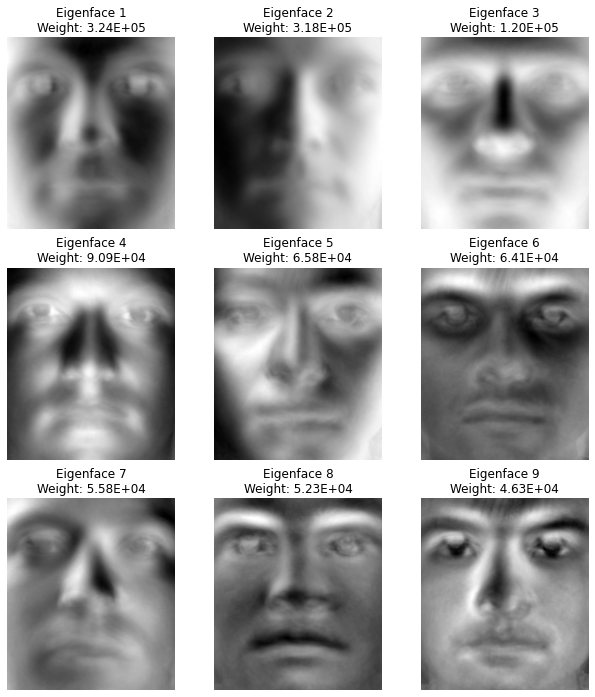

In [ ]:
# View eigenfaces
fig, axs = plt.subplots(3, 3, figsize = (12 * asp, 12))

for i in range(9):
  ax = axs[i // 3, i % 3]
  ax.imshow(np.reshape(U[:, i], (N,M)).T, cmap='gray')
  ax.axis('off')
  ax.set_title(f"Eigenface {i+1}\nWeight: {S[i]:.2E}")
plt.show()

### Reconstruction

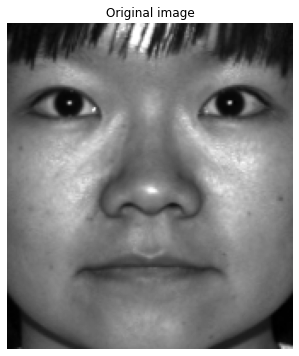

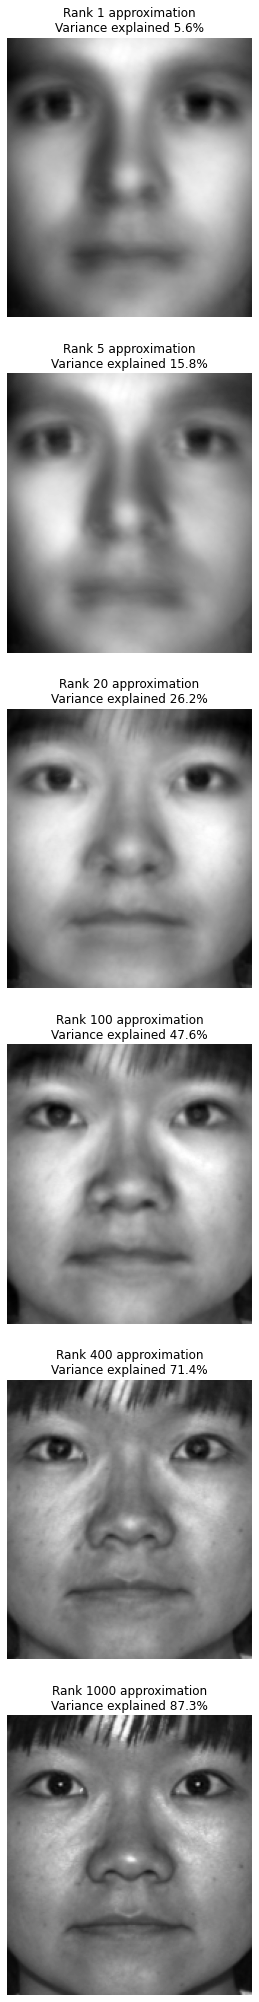

In [ ]:
# Show holdback image
fig, ax = plt.subplots(figsize = (6 * asp, 6))
ax.imshow(holdback.reshape((N, M)).T, cmap='gray')
ax.axis('off')
ax.set_title("Original image")
plt.show()

# Reconstruct holdback image using rank r approximation
fig, axs = plt.subplots(len(RANKS), 1, figsize = (6 * asp, 6 * len(RANKS)))
sum_sigma = np.sum(S)

for r, ax in zip(RANKS, axs):
  recon = mu + U[:,:r] @ (U[:,:r].T @ (holdback - mu))
  ax.imshow(recon.reshape((N, M)).T, cmap='gray')
  ax.axis('off')
  ax.set_title(f"Rank {r} approximation\n" +
               f"Variance explained {np.sum(S[:r]) / sum_sigma * 100:.01f}%")
plt.show()

## Regression

_To be added after the session._

## Wider applications and Limitations

_See session three recording._